In [2]:

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from prettytable import PrettyTable

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
import time
import nltk
nltk.data.find('corpora/stopwords')

FileSystemPathPointer('/Users/felipe/nltk_data/corpora/stopwords')

## 1.- Cargar y preparar datos

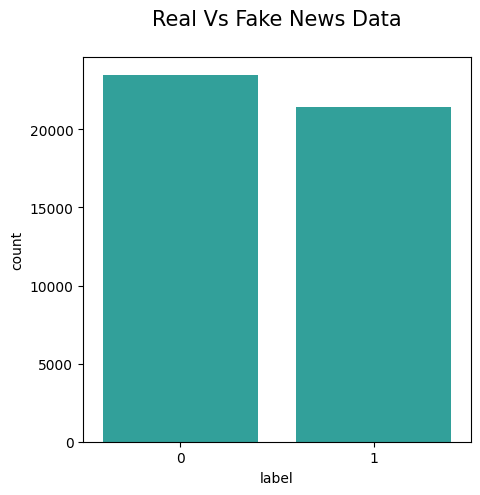

In [14]:
# --- 1. Load and Prepare Data ---
df_true = pd.read_csv("News _dataset/True.csv")
df_fake = pd.read_csv("News _dataset/Fake.csv")

# labels: 0 Fake, 1 True
df_fake['label'] = 0
df_true['label'] = 1

df_combined = pd.concat([df_fake, df_true], ignore_index=True)
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

# Eliminar datos con title o text vacíos
df_combined.dropna(subset=['title', 'text'], inplace=True)

plt.figure(figsize=(5,5))
sns.countplot(x="label", data=df_combined, color="lightseagreen")
plt.title("Real Vs Fake News Data\n",fontsize=15)
plt.show()


# 2.- Preprocesado de los datos

In [4]:
df_combined['full_text'] = df_combined['title'] + " " + df_combined['text']
X = df_combined['full_text']
y = df_combined['label']

stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Aplicar pre procesado para limpiar el texto
print("Pocesando datos.")
X_processed = X.apply(preprocess_text)
print("\nPreprocesado completo.")


Pocesando datos.

Preprocesado completo.


# 3.- Separar datos de entrenamiento y test

In [5]:
# 80% train, 20% test
# Stratify=y ensures the proportion of fake/true news is similar in both sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")



Training set size: 35918
Test set size: 8980


## Entrenamiento y evaluación de Regresión Logística


--- Model: Logistic Regression ---
Training Time: 33.16 seconds

Accuracy: 0.9909

Reporte:
              precision    recall  f1-score   support

    Fake (0)       0.99      0.99      0.99      4696
    True (1)       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



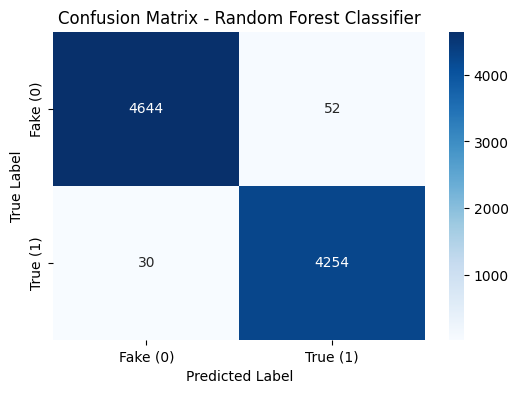

In [6]:
tfidf_vectorizer = TfidfVectorizer(max_features=15000, ngram_range=(1, 2))

print("\n--- Model: Logistic Regression ---")
pipeline_logreg = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('classifier', LogisticRegression(C=1.0, max_iter=1000, random_state=42, solver='liblinear'))
])
start_time = time.time()
pipeline_logreg.fit(X_train, y_train)
train_time_logreg = time.time() - start_time
print(f"Training Time: {train_time_logreg:.2f} seconds")

# --- Evaluar modelo ---
y_pred = pipeline_logreg.predict(X_test)
accuracy_logreg = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy_logreg:.4f}")

print("\nReporte:")
print(classification_report(y_test, y_pred, target_names=['Fake (0)', 'True (1)']))

# Guardar modelo
model_filename = 'pipeline_logreg.joblib'
joblib.dump(pipeline_logreg, model_filename)

cm_rl = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_rl, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake (0)', 'True (1)'],
            yticklabels=['Fake (0)', 'True (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.show()



## Entrenamiento y evaluación de Naive Bayes


--- Model: Multinomial Naive Bayes ---
Training Time: 32.81 seconds
Accuracy: 0.9573
Classification Report:
              precision    recall  f1-score   support

    Fake (0)       0.96      0.95      0.96      4696
    True (1)       0.95      0.96      0.96      4284

    accuracy                           0.96      8980
   macro avg       0.96      0.96      0.96      8980
weighted avg       0.96      0.96      0.96      8980



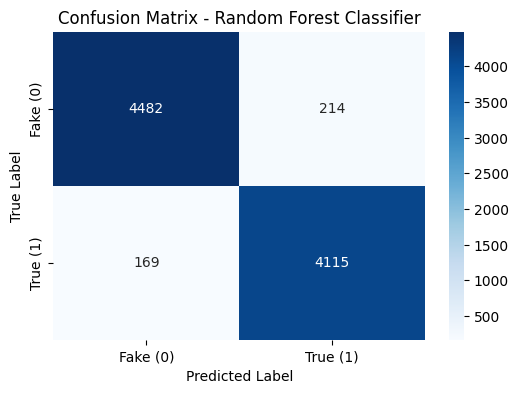

In [7]:
print("\n--- Model: Multinomial Naive Bayes ---")
pipeline_nb = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('classifier', MultinomialNB())
])

start_time = time.time()
pipeline_nb.fit(X_train, y_train)
train_time_nb = time.time() - start_time
print(f"Training Time: {train_time_nb:.2f} seconds")

y_pred_nb = pipeline_nb.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Accuracy: {accuracy_nb:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_nb, target_names=['Fake (0)', 'True (1)']))

# Guardar modelo
model_filename = 'pipeline_nb.joblib'
joblib.dump(pipeline_nb, model_filename)

cm_nb = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake (0)', 'True (1)'],
            yticklabels=['Fake (0)', 'True (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.show()


## Entrenamiento y evaluación de SVM


--- Model: Linear Support Vector Classifier (LinearSVC) ---
Training Time: 36.90 seconds
Accuracy: 0.9968
Classification Report:
              precision    recall  f1-score   support

    Fake (0)       1.00      1.00      1.00      4696
    True (1)       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



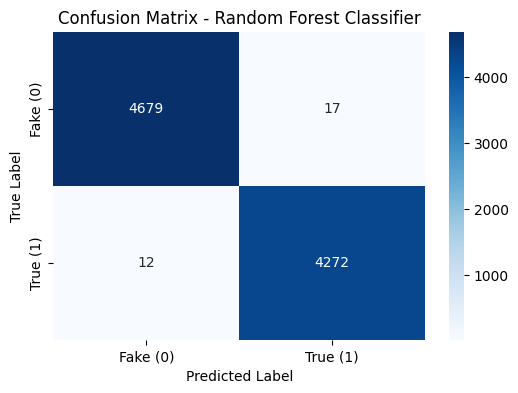

In [8]:
print("\n--- Model: Linear Support Vector Classifier (LinearSVC) ---")
pipeline_svm = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('classifier', LinearSVC(C=1.0, max_iter=2000, random_state=42, dual=True))
])

start_time = time.time()
pipeline_svm.fit(X_train, y_train)
train_time_svc = time.time() - start_time
print(f"Training Time: {train_time_svc:.2f} seconds")

# --- Evaluar modelo ---
y_pred_svc = pipeline_svm.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print(f"Accuracy: {accuracy_svc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_svc, target_names=['Fake (0)', 'True (1)']))

# Guardar modelo
model_filename = 'pipeline_svm.joblib'
joblib.dump(pipeline_svm, model_filename)

cm_svc = confusion_matrix(y_test, y_pred_svc)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake (0)', 'True (1)'],
            yticklabels=['Fake (0)', 'True (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.show()

## Entrenamiento y evaluación de Random Forest


--- Model: Random Forest Classifier ---
Training Time: 42.98 seconds

Evaluating Random Forest Classifier:
Accuracy: 0.9972
Classification Report:
              precision    recall  f1-score   support

    Fake (0)       1.00      1.00      1.00      4696
    True (1)       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



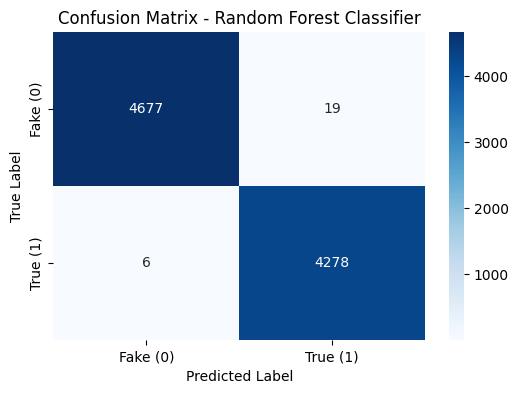

In [9]:
print("\n--- Model: Random Forest Classifier ---")
pipeline_rf = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])

start_time = time.time()
pipeline_rf.fit(X_train, y_train)
train_time_rf = time.time() - start_time
print(f"Training Time: {train_time_rf:.2f} seconds")

print("\nEvaluating Random Forest Classifier:")
y_pred_rf = pipeline_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Fake (0)', 'True (1)']))

# Guardar modelo
model_filename = 'pipeline_rf.joblib'
joblib.dump(pipeline_rf, model_filename)

cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake (0)', 'True (1)'],
            yticklabels=['Fake (0)', 'True (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.show()

## Resumen

In [10]:
print("\n--- Model Performance Summary ---")
print(f"Logistic Regression: Accuracy={accuracy_logreg:.4f}, Train Time={train_time_logreg:.2f}s")
print(f"Multinomial NB     : Accuracy={accuracy_nb:.4f}, Train Time={train_time_nb:.2f}s")
print(f"Linear SVC         : Accuracy={accuracy_svc:.4f}, Train Time={train_time_svc:.2f}s")
print(f"Random Forest      : Accuracy={accuracy_rf:.4f}, Train Time={train_time_rf:.2f}s")


--- Model Performance Summary ---
Logistic Regression: Accuracy=0.9909, Train Time=33.16s
Multinomial NB     : Accuracy=0.9573, Train Time=32.81s
Linear SVC         : Accuracy=0.9968, Train Time=36.90s
Random Forest      : Accuracy=0.9972, Train Time=42.98s


In [12]:
def test_string_on_models(input_string):
    print(f"\n===== Probando Cadena de Entrada =====")
    # Mostrar solo una parte del texto original y procesado si son muy largos
    original_display = (input_string[:117] + '...') if len(input_string) > 120 else input_string
    print(f"Original ({len(input_string)} caracteres): '{original_display}'")

    # Asumimos que 'preprocess_text' es una función que tienes definida
    # y que tus pipelines esperan el texto preprocesado por esta función
    # si tus pipelines ya se encargan de todo el preprocesamiento (ej: TfidfVectorizer),
    # podrías pasar 'input_string' directamente a 'pipeline_model.predict'.
    processed_string = preprocess_text(input_string) # Usa tu función
    processed_display = (processed_string[:117] + '...') if len(processed_string) > 120 else processed_string
    print(f"Procesada ({len(processed_string)} caracteres): '{processed_display}'")

    input_data_for_pipeline = [processed_string] # O [input_string] si no usas preprocess_text aquí

    # Definición de los modelos a probar (asegúrate que estos pipelines estén definidos y entrenados)
    models = {
        "Regresión Logística": pipeline_logreg,
        "Multinomial NB": pipeline_nb,
        "Linear SVC": pipeline_svm,
        "Random Forest": pipeline_rf
    }

    # Crear la tabla para los resultados
    tabla_resultados = PrettyTable()
    tabla_resultados.field_names = ["Modelo", "Predicción", "Etiqueta", "Conf. Falsa (%)", "Conf. Verdadera (%)", "Valor Decisión"]
    tabla_resultados.align["Modelo"] = "l"  # Alinear nombres de modelo a la izquierda
    tabla_resultados.align["Predicción"] = "l"
    tabla_resultados.float_format = ".2" # Formato para los flotantes (ej: porcentajes)

    print("\n--- Predicciones de los Modelos ---")
    for model_name, pipeline_model in models.items():
        prediccion_num = pipeline_model.predict(input_data_for_pipeline)[0]
        etiqueta_predicha = "Verdadera" if prediccion_num == 1 else "Falsa"

        conf_falsa_str = "N/A"
        conf_verdadera_str = "N/A"
        valor_decision_str = "N/A"

        if hasattr(pipeline_model, "predict_proba"):
            probabilidades = pipeline_model.predict_proba(input_data_for_pipeline)[0]
            # Asegurar el orden correcto de las clases para las probabilidades
            try:
                idx_clase_0 = list(pipeline_model.classes_).index(0)
                idx_clase_1 = list(pipeline_model.classes_).index(1)
                conf_falsa_str = f"{probabilidades[idx_clase_0] * 100:.2f}"
                conf_verdadera_str = f"{probabilidades[idx_clase_1] * 100:.2f}"
            except ValueError: # En caso de que alguna clase (0 o 1) no esté en .classes_ (raro)
                conf_falsa_str = "Error clases"
                conf_verdadera_str = "Error clases"

        elif hasattr(pipeline_model, "decision_function"):
            # Para modelos como SVC que no tienen predict_proba por defecto con kernel lineal
            valor_decision = pipeline_model.decision_function(input_data_for_pipeline)[0]
            valor_decision_str = f"{valor_decision:.4f}"
        else:
            # Si el modelo no ofrece ninguna de estas medidas
            pass # Las cadenas ya son "N/A"

        tabla_resultados.add_row([
            model_name,
            etiqueta_predicha,
            prediccion_num,
            conf_falsa_str,
            conf_verdadera_str,
            valor_decision_str
        ])

    print(tabla_resultados)
    print("Nota sobre Predicción: Generalmente, un valor > 0 sugiere 'Verdadera' y < 0 sugiere 'Falsa'.")
    print("======================================")


test_string_true = "The Central Bank announced today a quarter-point interest rate hike following its policy meeting, citing persistent inflation concerns."
test_string_on_models(test_string_true)

test_string_fake = "SHOCKING: Scientists forced to admit Bigfoot filmed in Oregon forest, government conspiracy tries to hide the truth!! WATCH NOW!"
test_string_on_models(test_string_fake)

test_string_ambiguous = "Study suggests link between excessive smartphone use and memory problems in teenagers, researchers urge caution."
test_string_on_models(test_string_ambiguous)

my_custom_string = "According to local reports, the city council is debating a new proposal for expanding public transportation options next year."
test_string_on_models(my_custom_string)

my_custom_string = "Jurors began deliberating Thursday in the case of two men charged with cutting down the Sycamore Gap tree that once stood along the ancient Hadrian's Wall in northern England. Daniel Graham, 39, and Adam Carruthers, 32, have pleaded not guilty to two counts each of criminal damage. The former friends each testified that they were at their separate homes that night and not involved. Justice Christina Lambert told jurors in Newcastle Crown Court to take as long as they need to reach unanimous verdicts in the trial that began April 28. The tree was not Britain’s biggest or oldest, but it was prized for its picturesque setting along the ancient wall built by Emperor Hadrian in A.D. 122 to protect the northwest frontier of the Roman Empire."
test_string_on_models(my_custom_string)




===== Probando Cadena de Entrada =====
Original (135 caracteres): 'The Central Bank announced today a quarter-point interest rate hike following its policy meeting, citing persistent i...'
Procesada (122 caracteres): 'central bank announced today quarterpoint interest rate hike following policy meeting citing persistent inflation con...'

--- Predicciones de los Modelos ---
+---------------------+------------+----------+-----------------+---------------------+----------------+
| Modelo              | Predicción | Etiqueta | Conf. Falsa (%) | Conf. Verdadera (%) | Valor Decisión |
+---------------------+------------+----------+-----------------+---------------------+----------------+
| Regresión Logística | Falsa      |    0     |      61.55      |        38.45        |      N/A       |
| Multinomial NB      | Verdadera  |    1     |       5.91      |        94.09        |      N/A       |
| Linear SVC          | Falsa      |    0     |       N/A       |         N/A         |    -0.265